In [0]:
!pip install -q tensorflow_hub

In [2]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0328 16:17:40.196524 140035866412928 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

Download dataset

In [3]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


228818944/228813984 [==============================] - 3s 0us/step


Load data into our model

In [4]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


In [5]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


Dowload image classifier

In [0]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [8]:
def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

Instructions for updating:
Colocations handled automatically by placer.


W0328 16:20:58.028014 140035866412928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 16:21:32.398292 140035866412928 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Rebuild the data generator, with the output size set to match what's expected by the module

In [10]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Initialise TFHub modules

In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

Download a single image to try the model on

65536/61306 [================================] - 0s 0us/step


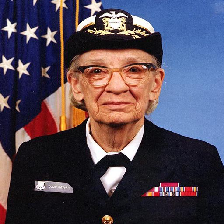

In [12]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [13]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

Add a batch dimension, and pass the image to the model.

In [14]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [15]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

Decode predictions

In [16]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


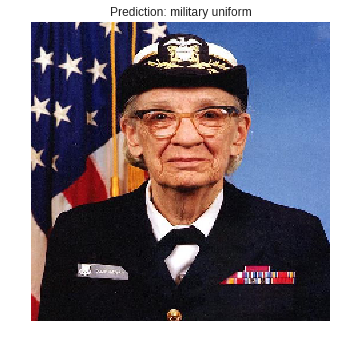

In [17]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name)

Now run the classifier on the image batch.

In [18]:
result_batch = classifier_model.predict(image_batch)


labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['fly', 'daisy', 'cardoon', 'daisy', 'daisy', 'daisy',
       "yellow lady's slipper", 'daisy', 'daisy', 'coral fungus', 'hip',
       'daisy', 'banana', 'paper towel', 'daisy', 'limpkin', 'conch',
       'daisy', 'picket fence', 'tractor', 'daisy', 'feather boa', 'mask',
       'picket fence', 'fly', 'bee', 'bonnet', 'strawberry', 'daisy',
       'picket fence', 'daisy', 'rapeseed'], dtype='<U30')

Now check how these predictions line up with the images:

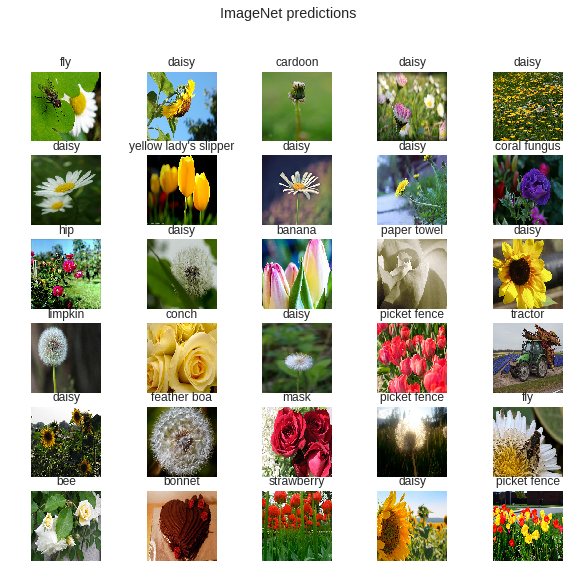

In [19]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

Simple transfer learning

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size

In [0]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size

In [24]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Wrap the module in a keras layer

In [0]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer

In [0]:
features_extractor_layer.trainable = False

Attach a classification head

In [27]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 16:38:34.824600 140035866412928 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


Initialize the TFHub module

In [0]:
init = tf.global_variables_initializer()
sess.run(init)

Test run a single batch, to see that the result comes back with the expected shape

In [29]:
result = model.predict(image_batch)
result.shape

(32, 5)

Train the model

In [0]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Continue training 

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [32]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Instructions for updating:
Use tf.cast instead.


W0328 16:41:37.591590 140035866412928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


114/114 [==============================] - 182s 2s/step - loss: 0.6699 - acc: 0.7554


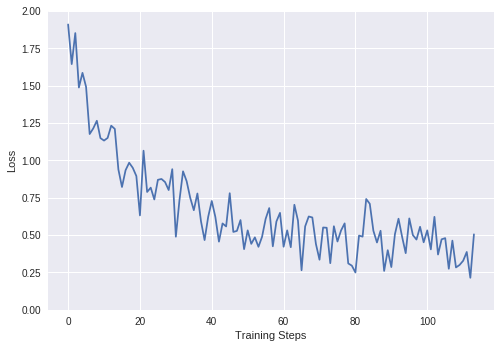

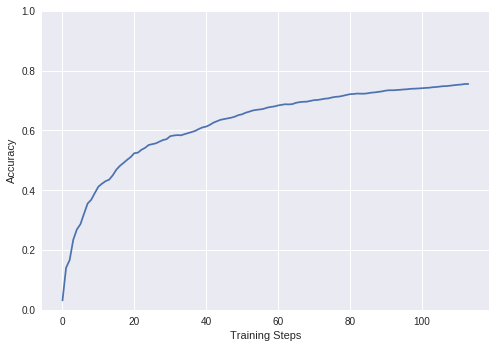

In [33]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

Check the predictions

In [34]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and convert the indices to class names.

In [36]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Dandelion', 'Sunflowers', 'Roses', 'Daisy', 'Roses', 'Sunflowers',
       'Roses', 'Tulips', 'Sunflowers', 'Daisy', 'Tulips', 'Dandelion',
       'Dandelion', 'Dandelion', 'Tulips', 'Sunflowers', 'Sunflowers',
       'Tulips', 'Tulips', 'Roses', 'Sunflowers', 'Dandelion', 'Tulips',
       'Dandelion', 'Daisy', 'Sunflowers', 'Roses', 'Roses', 'Tulips',
       'Daisy', 'Daisy', 'Sunflowers'], dtype='<U10')

Plot results


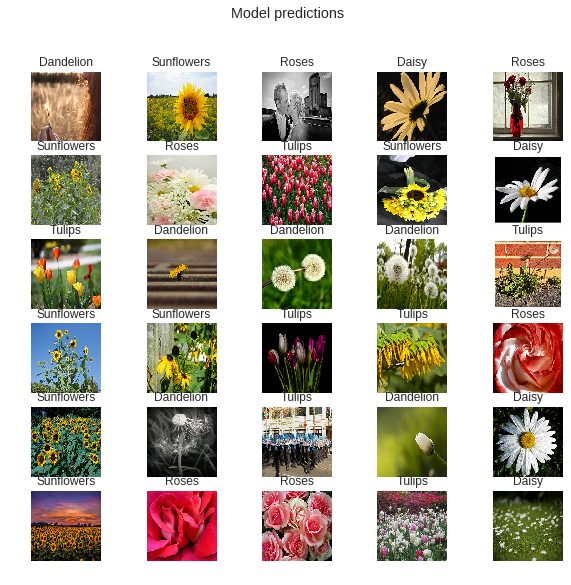

In [37]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [38]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


W0328 16:51:25.482377 140035866412928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/network.py:1436: update_checkpoint_state (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 16:51:29.167012 140035866412928 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


W0328 16:51:31.198183 140035866412928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:257: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 16:51:31.200607 140035866412928 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 16:51:31.208666 140035866412928 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0328 16:51:31.211499 140035866412928 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


I0328 16:51:31.224846 140035866412928 export.py:587] Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 16:51:31.228156 140035866412928 export.py:587] Signatures INCLUDED in export for Eval: None


W0328 16:51:31.231081 140035866412928 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0328 16:51:31.932439 140035866412928 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0328 16:51:31.938862 140035866412928 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 16:51:35.072641 140035866412928 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 16:51:36.350288 140035866412928 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 16:51:36.352191 140035866412928 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


I0328 16:51:36.360107 140035866412928 export.py:587] Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 16:51:36.364313 140035866412928 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: ['eval']


I0328 16:51:36.368260 140035866412928 export.py:587] Signatures INCLUDED in export for Eval: ['eval']


W0328 16:51:36.372027 140035866412928 tf_logging.py:161] Export includes no default signature!


INFO:tensorflow:No assets to save.


I0328 16:51:36.951673 140035866412928 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0328 16:51:36.955219 140035866412928 builder_impl.py:124] No assets to write.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0328 16:51:40.741525 140035866412928 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


I0328 16:51:41.797689 140035866412928 export.py:587] Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


I0328 16:51:41.799830 140035866412928 export.py:587] Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


I0328 16:51:41.809406 140035866412928 export.py:587] Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


I0328 16:51:41.812935 140035866412928 export.py:587] Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


I0328 16:51:41.817134 140035866412928 export.py:587] Signatures INCLUDED in export for Eval: None


INFO:tensorflow:No assets to save.


I0328 16:51:42.387834 140035866412928 builder_impl.py:629] No assets to save.


INFO:tensorflow:No assets to write.


I0328 16:51:42.389964 140035866412928 builder_impl.py:124] No assets to write.


INFO:tensorflow:SavedModel written to: ./saved_models/1553791883/saved_model.pb


I0328 16:51:42.945252 140035866412928 builder_impl.py:414] SavedModel written to: ./saved_models/1553791883/saved_model.pb


b'./saved_models/1553791883'